# Key issues to deepen Big Data analysis



Can we observe any trends in popularity or other characteristics according to the year of release?

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, isnan, when, count, mean ,stddev, expr, corr

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, IntegerType

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a SparkSession

In [2]:
spark = SparkSession.builder.appName("Spotify Curiosity").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/15 11:49:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

# 2. Data loading and cleaning¶

In [4]:
# Read CSV file into DataFrame with header
csv_file_path =("./data/spotify_cleaned.csv")
df = spark.read.csv(csv_file_path,header=True,inferSchema=True)

                                                                                24/11/15 11:49:57 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- key: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- formatted_date: date (nullable = true)
 |-- tempo_category: string (nullable = true)
 |-- duration_category: string (nullable = true)



# What is the average length of the most popular songs (e.g., top 10% popularity)?

In [6]:
popularity_threshold = df.approxQuantile("popularity",[0.9],0.01)[0]

In [7]:
top_songs = df.filter(col("popularity")>= popularity_threshold)
avg_duration_top_songs = top_songs.selectExpr("avg(duration_ms) as avg_duration").collect()[0]["avg_duration"]


In [8]:
print(f"The average lenght of the most popular songs: {avg_duration_top_songs}")

The average lenght of the most popular songs: 223602.33238080118


# Can we observe any trends in popularity or other characteristics according to the year of release?


In [12]:
popularity_by_year = df.groupBy("formatted_date").avg("popularity").orderBy("formatted_date")
popularity_by_year.show()

+--------------+-------------------+
|formatted_date|    avg(popularity)|
+--------------+-------------------+
|    1921-01-01|0.47368421052631576|
|    1921-02-20|                0.0|
|    1921-03-20|                0.0|
|    1921-03-27|                0.0|
|    1921-04-12|                0.0|
|    1921-09-11|                0.0|
|    1921-12-18|                0.0|
|    1922-01-01|                0.0|
|    1922-02-22| 1.6666666666666667|
|    1922-03-21|                0.0|
|    1922-03-29|                0.0|
|    1923-01-01|              7.696|
|    1923-01-04|                0.0|
|    1923-03-25|                2.0|
|    1923-03-29|                0.0|
|    1923-07-09|                0.0|
|    1923-12-18|                0.0|
|    1924-01-01| 1.0671641791044777|
|    1924-03-29|                0.0|
|    1924-07-11|                0.0|
+--------------+-------------------+
only showing top 20 rows



In [13]:
popularity_by_year_pd = popularity_by_year.toPandas()

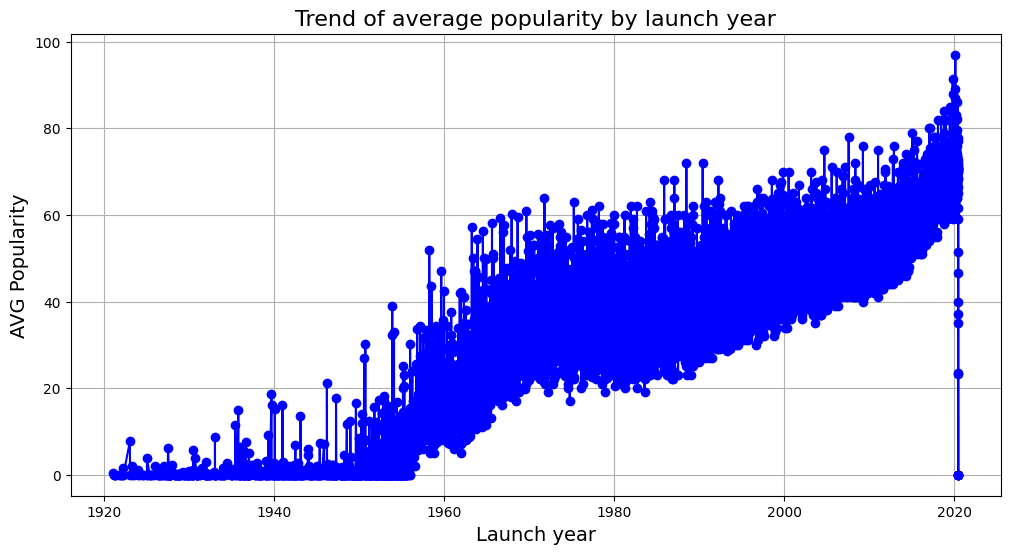

In [16]:
plt.figure(figsize=(12,6))
plt.plot(popularity_by_year_pd["formatted_date"], popularity_by_year_pd["avg(popularity)"], marker='o', color='b')
plt.title("Trend of average popularity by launch year",fontsize=16)
plt.xlabel("Launch year", fontsize=14)
plt.ylabel("AVG Popularity", fontsize=14)
plt.grid(True)
plt.show()

# What clusters of songs are formed according to 'tempo', 'valence', and 'danceability'.?

In [17]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


In [20]:
# Select the columns by the cluster
feature_cols = ["tempo", "valence", "danceability"]

In [21]:
# Create a caracteristics vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df)

In [23]:
# Scaling the characteristics
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

In [24]:
from pyspark.ml.clustering import KMeans

24/11/15 12:10:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/15 12:10:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


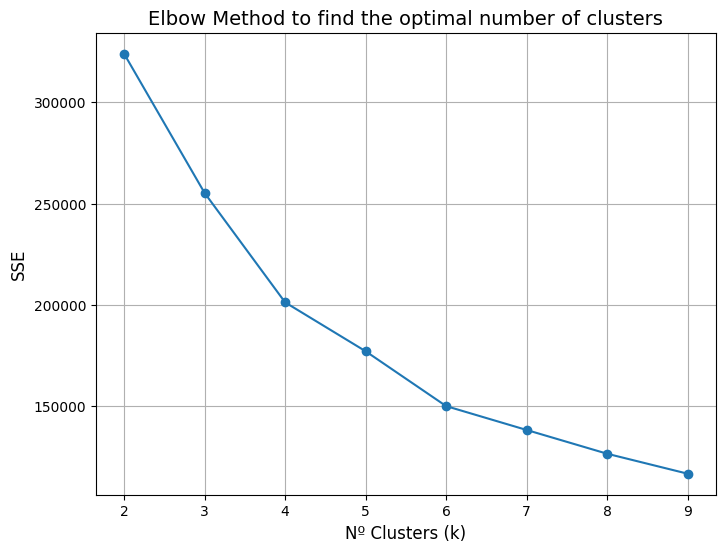

In [25]:
# Test different values of K

cost = []
for k in range(2, 10):  
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    cost.append(model.summary.trainingCost)

# "Elbow Method"
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), cost, marker='o')
plt.title("Elbow Method to find the optimal number of clusters",  fontsize=14)
plt.xlabel("Nº Clusters (k)", fontsize=12)
plt.ylabel("SSE", fontsize=12)
plt.grid(True)
plt.show()

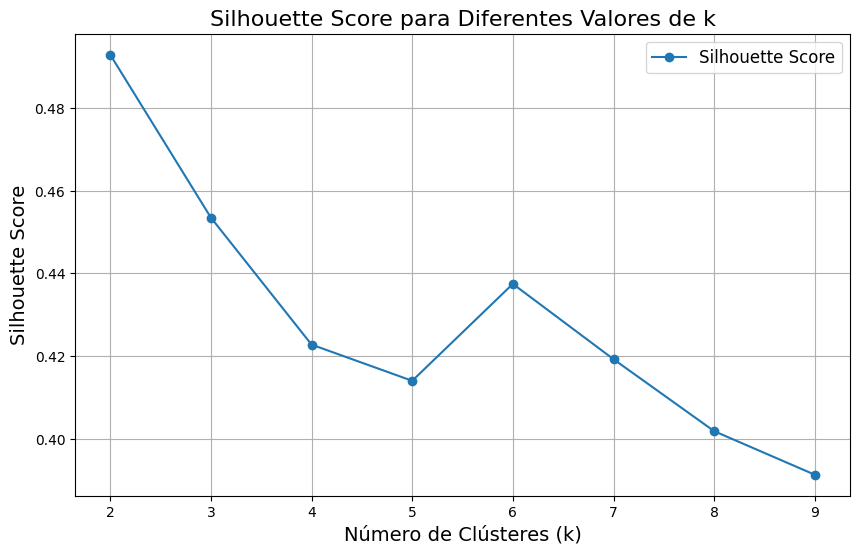

In [33]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette")

silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o', label='Silhouette Score')
plt.title("Silhouette Score for  k", fontsize=16)
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


- If you prefer well-defined and more compact clusters, use k=2.
- If you need more granularity in the clusters, opt for k=5, as it presents an acceptable Silhouette Score and matches the results of the Elbow Method.

**Final Considerations**
  
Although k=2 has the best score, in contexts such as music (where there are many potential categories), a value such as k=4 or k=5 may be more useful for detailed and practical analysis.

In [35]:
# K-means with k=4
k = 4
kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
model = kmeans.fit(df_scaled)
df_clusters = model.transform(df_scaled)

# Add the columna of clúster to DataFrame
df_clusters = df_clusters.withColumnRenamed("prediction", "cluster")


In [36]:
# Calculate descriptive statistics by cluster
cluster_summary = df_clusters.groupBy("cluster").avg("tempo", "valence", "danceability").orderBy("cluster")
cluster_summary.show()


+-------+------------------+-------------------+-------------------+
|cluster|        avg(tempo)|       avg(valence)|  avg(danceability)|
+-------+------------------+-------------------+-------------------+
|      0|101.74198787718802|0.46024175973683135| 0.5793849043577136|
|      1|159.61724561503254| 0.5287528248571498|0.44796381158143095|
|      2| 95.05011837956116|0.20816320937962537|0.31893894716519733|
|      3|115.94979171465802| 0.7979315156435891| 0.6923145144540325|
+-------+------------------+-------------------+-------------------+



- Cluster 0: “Calm and positive” (low tempo, high valence)
- Cluster 1: “Energetic and danceable” (high tempo, high valence and danceability)
- Cluster 2: “Melancholic and relaxed” (low tempo, low valence)
- Cluster 3: “Rhythmic and vibrant” (high tempo and danceability, moderate valence)

In [39]:
df_clusters_pd = df_clusters.select("tempo", "valence", "danceability", "cluster").toPandas()

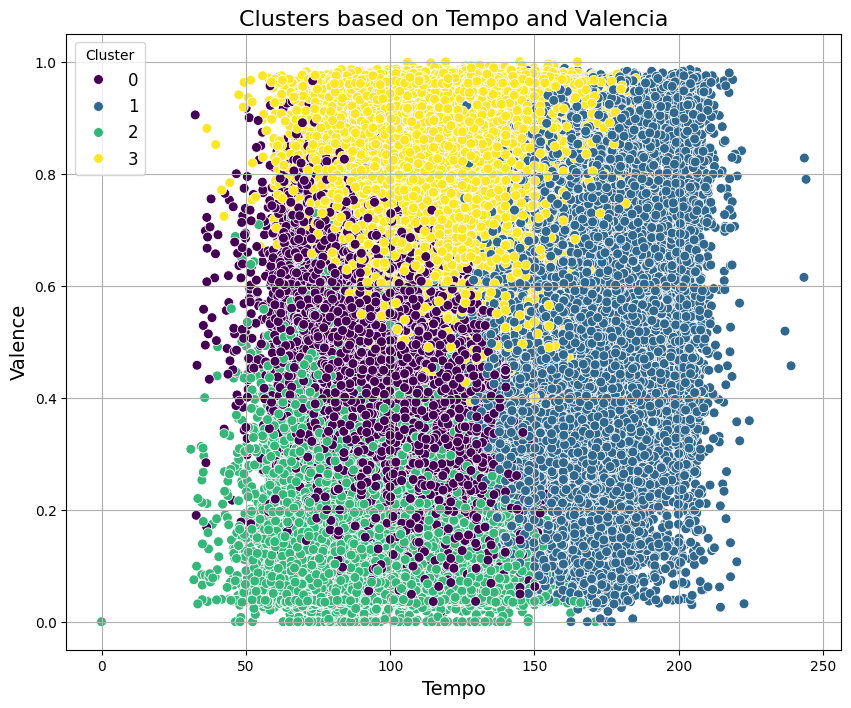

In [40]:
# Visualization
plt.figure(figsize=(10 ,8))
sns.scatterplot(data=df_clusters_pd, x="tempo",y="valence", hue="cluster", palette="viridis", s=50)
plt.title("Clusters based on Tempo and Valencia", fontsize=16)
plt.xlabel("Tempo", fontsize=14)
plt.ylabel("Valence", fontsize=14)
plt.legend(title="Cluster", fontsize=12)
plt.grid(True)
plt.show()

# Which artists have the highest proportion of popular songs with high 'danceability'?

In [66]:
# Threshold
popularity_threshold = 70
danceability_threshold = 0.6

In [67]:
# Create a column that indicates whether the song meets the following conditions
df_filtered = df.withColumn("is_popular_danceable",
                            when((col("popularity") > popularity_threshold) & (col("danceability") > danceability_threshold),1
                           ).otherwise(0).cast("int")
                           )

In [90]:
df_filtered = df_filtered.withColumn(
    "is_popular_danceable", 
    col("is_popular_danceable").cast(IntegerType())
)

In [92]:
df_filtered.select(col("is_popular_danceable")).distinct().show()

+--------------------+
|is_popular_danceable|
+--------------------+
|                   1|
|                   0|
+--------------------+



In [93]:
df_filtered.filter(col("is_popular_danceable") == 1).count()

2571

In [96]:
# count the total number of songs
artist_stats = df_filtered.groupBy("artists").agg(
    count("*").alias("total_songs"),
    count(when((col("is_popular_danceable") == 1), 1).otherwise(None)).alias("popular_danceable_songs")
)
artist_stats.show()

+--------------------+-----------+-----------------------+
|             artists|total_songs|popular_danceable_songs|
+--------------------+-----------+-----------------------+
|           ['Damia']|         16|                      0|
|['Benny Goodman Q...|          4|                      0|
|    ['The Drifters']|         33|                      0|
|   ['Wanda Jackson']|         25|                      0|
|['Martha Reeves &...|         30|                      0|
|   ['The Guess Who']|         48|                      0|
|['Diana Ross & Th...|          6|                      0|
|  ['Stealers Wheel']|          5|                      1|
|['Blue Öyster Cult']|         67|                      0|
|     ['Gary Wright']|          7|                      0|
|     ['Joe Jackson']|         30|                      0|
|       ['Dan Seals']|          7|                      0|
|['The Flaming Lips']|         22|                      0|
|['Eminem', 'Lil W...|          1|                      

In [103]:
artist_stats.orderBy(col("popular_danceable_songs"), ascending=False).show(10)

+-----------------+-----------+-----------------------+
|          artists|total_songs|popular_danceable_songs|
+-----------------+-----------+-----------------------+
|   ['Juice WRLD']|         40|                     19|
|    ['Bad Bunny']|         30|                     19|
|          ['BTS']|        117|                     19|
|        ['Drake']|        128|                     18|
| ['Lil Uzi Vert']|         85|                     18|
|['Billie Eilish']|         30|                     17|
|     ['Dua Lipa']|         24|                     17|
| ['Travis Scott']|         40|                     17|
|['Ariana Grande']|         49|                     16|
| ['Taylor Swift']|        189|                     16|
+-----------------+-----------+-----------------------+
only showing top 10 rows

